# 下面是`dataset.py`的分析
## 以`ml-100k`为例

In [1]:
import argparse
from audioop import rms
import logging
import os
import sys
from itertools import product
from time import localtime, sleep, strftime, time
# import time

import numpy as np
import setproctitle # to set the name of process
import torch
import torch.utils
from tensorboardX import SummaryWriter
from torch import multiprocessing as mp # 多线程工作

from dataset import get_data_queue_cf, get_data_queue_cf_nonsparse, get_data_queue_efficiently, get_data_queue_negsampling_efficiently
from models import (CML, DELF, DMF, FISM, GMF, MLP, SVD, JNCF_Cat, JNCF_Dot, SVD_plus_plus, SPACE, BaseModel, Virtue_CF)
from controller import sample_arch_cf, sample_arch_cf_signal, sample_arch_cf_test
from train_eval import (evaluate_cf, evaluate_cf_efficiently, evaluate_cf_efficiently_implicit, get_arch_performance_cf_signal_param_device, get_arch_performance_single_device, train_single_cf, train_single_cf_efficiently,get_arch_performance_implicit_single_device)
from sklearn.utils import shuffle

import GPUtil
import socket
import math
import scipy.sparse as sp


%load_ext autoreload
%autoreload 2

In [92]:
parser = argparse.ArgumentParser(description="Run.")
parser.add_argument('--lr', type=float, default=0.05, help='init learning rate')
parser.add_argument('--arch_lr', type=float, default=0.05, help='learning rate for arch encoding')
parser.add_argument('--controller_lr', type=float, default=1e-1, help='learning rate for controller')
parser.add_argument('--weight_decay', type=float, default=1e-5, help='weight decay')
parser.add_argument('--update_freq', type=int, default=1, help='frequency of updating architeture')
parser.add_argument('--opt', type=str, default='Adagrad', help='choice of opt')
parser.add_argument('--use_gpu', type=int, default=1, help='whether use gpu')
parser.add_argument('--minibatch', type=int, default=1, help='whether use minibatch')
parser.add_argument('--gpu', type=int, default=0, help='gpu device id')
parser.add_argument('--train_epochs', type=int, default=2000, help='num of training epochs')
parser.add_argument('--search_epochs', type=int, default=1000, help='num of searching epochs')
parser.add_argument('--save', type=str, default='save/', help='experiment name')
parser.add_argument('--seed', type=int, default=1, help='random seed')
parser.add_argument('--grad_clip', type=float, default=5, help='gradient clipping')
parser.add_argument('--train_portion', type=float, default=0.5, help='portion of training data')
parser.add_argument('--valid_portion', type=float, default=0.25, help='portion of validation data')
parser.add_argument('--dataset', type=str, default='ml-100k', help='dataset')
parser.add_argument('--mode', type=str, default='random_single', help='search or single mode')
parser.add_argument('--process_name', type=str, default='AutoCF@wenyan', help='process name')
parser.add_argument('--embedding_dim', type=int, default=2, help='dimension of embedding')
parser.add_argument('--controller', type=str, default='PURE', help='structure of controller')
parser.add_argument('--controller_batch_size', type=int, default=4, help='batch size for updating controller')
parser.add_argument('--unrolled', action='store_true', default=True, help='use one-step unrolled validation loss')
parser.add_argument('--max_batch', type=int, default=65536, help='max batch during training')
parser.add_argument('--device', type=int, default=0, help='GPU device')
parser.add_argument('--multi', type=int, default=0, help='using multi-training for single architecture')
parser.add_argument('--if_valid', type=int, default=1, help='use validation set for tuning single architecture or not')
parser.add_argument('--breakpoint', type=str, default='save/log.txt', help='the log file storing existing results')
parser.add_argument('--arch_file', type=str, default='src/arch.txt', help='all arches')
parser.add_argument('--remaining_arches', type=str, default='src/arch.txt', help='')
parser.add_argument('--arch_assign', type=str, default='[0,3]', help='')
parser.add_argument('--data_type', type=str, default='implicit', help='explicit or implicit(default)')
parser.add_argument('--loss_func', type=str, default='bprloss', help='Implicit loss function')
parser.add_argument('--mark', type=str, default='') # 
parser.add_argument('--sample_portion', type=float, default=0.9, help='portion of data subgraph')
parser.add_argument('--anchor_num', type=int, default=15, help='size of anchor sample number')
parser.add_argument('--sample_mode', type=str, default='distribute', help='topk or distribute mode of sampling')

args = parser.parse_args([])
mp.set_start_method('spawn', force=True) # 一种多任务运行方法
args.dataset = 'ml-100k'

In [93]:
# 以下文件来自`dataset.py`
'''implicit数据集组织方法'''
args.datset = 'ml-100k'
data_path = args.dataset + '/'
users, items, labels = [], [], []
if args.dataset == 'ml-100k':
    data_path += 'u.data'
else:
    pass
data_path = 'data/' + data_path
print("data_path: {}".format(data_path))

with open(data_path, 'r') as f:
    for i, line in enumerate(f.readlines()):
        # e.g. line = 196	242	3	881250949
        if args.dataset == 'ml-100k':
            line = line.split()
        elif args.dataset == 'ml-1m' or args.dataset == 'ml-10m':
            line = line.split('::')
        elif args.dataset == 'ml-20m':
            if i == 0:
                continue
            line = line.split(',')
        elif args.dataset == 'amazon-book':
            line = line.split(',')
        elif args.dataset == 'yelp' or 'yelp2':
            line = line.split(',')
        user = int(line[0]) - 1 if args.dataset != 'amazon-book' and args.dataset != 'yelp' and args.dataset != 'yelp2' else int(line[0])
        item = int(line[1]) - 1 if args.dataset != 'amazon-book' and args.dataset != 'yelp' and args.dataset != 'yelp2' else int(line[1])
        label = float(line[2])
        users.append(user)
        items.append(item)
        labels.append(label)
# labels = StandardScaler().fit_transform(np.reshape(labels, [-1, 1])).flatten().tolist()

# users, items, labels = shuffle(users, items, labels)

data_path: data/ml-100k/u.data


In [94]:
print('\n[Origin data]')
users, items, labels = shuffle(users, items, labels)
num_train = int(len(users) * args.train_portion)
num_valid = int(len(users) * args.valid_portion)
print("num_train: {}, num_valid: {}".format(num_train, num_valid))
num_users = max(users) + 1
num_items = max(items) + 1
# num_users = args.num_users
# num_items = args.num_items
# print('num_users',num_users,'num_items', num_items)
print("num_users: {}, num_items: {}".format(num_users,num_items))
user_interactions = torch.from_numpy(sp.coo_matrix(
    (labels, (users, items)), shape=(num_users, num_items)).tocsr().toarray())
item_interactions = torch.from_numpy(sp.coo_matrix(
    (labels, (items, users)), shape=(num_items, num_users)).tocsr().toarray())


[Origin data]
num_train: 50000, num_valid: 25000
num_users: 943, num_items: 1682


In [95]:
from dataset import subample_from_item_interaction_freq, subample_from_item_freq_distributed
args.sample_mode = 'distribute'
item_down_sample_portion = 0.5
if args.sample_mode == 'topk':
    users_sampled, items_sampled, labels_sampled = subample_from_item_interaction_freq(item_interactions, item_down_sample_portion)
elif args.sample_mode == 'distribute':
    users_sampled, items_sampled, labels_sampled = subample_from_item_freq_distributed(item_interactions, item_down_sample_portion)
else:
    users_sampled, items_sampled, labels_sampled = subample_from_item_interaction_freq(item_interactions, item_down_sample_portion)


item_freqency.shape: torch.Size([1682])
item_sample_prob[:20]: tensor([4.5200e-03, 1.3100e-03, 9.0000e-04, 2.0900e-03, 8.6000e-04, 2.6000e-04,
        3.9200e-03, 2.1900e-03, 2.9900e-03, 8.9000e-04, 2.3600e-03, 2.6700e-03,
        1.8400e-03, 1.8300e-03, 2.9300e-03, 3.9000e-04, 9.2000e-04, 1.0000e-04,
        6.9000e-04, 7.2000e-04]), min: 9.999999747378752e-06, max: 0.005830000154674053, sum: 1.0
item_sampled[:20]: [287.  14. 212.  96. 171.  12. 290. 470. 266. 182. 601. 410. 404. 584.
 222. 345. 679. 215. 168. 203.]
item_interactions_sampled.shape: torch.Size([841, 943])


In [96]:
print('\n[Subsampled data]')
users, items, labels = shuffle(users_sampled, items_sampled, labels_sampled)
num_train = int(len(users) * args.train_portion)
num_valid = int(len(users) * args.valid_portion)
print("num_train: {}, num_valid: {}".format(num_train, num_valid))

users_train = np.array(users[:num_train], dtype=np.int32)
items_train = np.array(items[:num_train], dtype=np.int32)
labels_train = np.array(labels[:num_train], dtype=np.float32)

num_users = max(users) + 1
num_items = max(items) + 1
args.num_users = num_users
args.num_items = num_items  
# print('num_users',num_users,'num_items', num_items)
print("num_users: {}, num_items: {}".format(num_users,num_items))

user_interactions = torch.from_numpy(sp.coo_matrix(
    (labels_train, (users_train, items_train)), shape=(num_users, num_items)).tocsr().toarray())
item_interactions = torch.from_numpy(sp.coo_matrix(
    (labels_train, (items_train, users_train)), shape=(num_items, num_users)).tocsr().toarray())
# print('item_interactions', item_interactions[:5,:5])
print("user_interactions.shape: {}".format(user_interactions.shape))
print("item_interactions.shape: {}".format(item_interactions.shape))




[Subsampled data]
num_train: 43616, num_valid: 21808
num_users: 943, num_items: 841
user_interactions.shape: torch.Size([943, 841])
item_interactions.shape: torch.Size([841, 943])


In [97]:
negs_train = np.zeros(len(labels_train), dtype=np.int64)
for k in range(len(labels_train)):# users_train中的用户遍历
    neg = np.random.randint(num_items)
    while user_interactions[users_train[k], neg] != 0:
        neg = np.random.randint(num_items) # neg是未与此uk交互的item的index
    negs_train[k] = neg # 得到的neg满足user_interactions[users_train[k], neg] == 0
negs_train = torch.from_numpy(negs_train)

train_queue_pair = [torch.tensor(users[:num_train]),
                    torch.tensor(items[:num_train]),
                    negs_train, # implicit特有的
                    user_interactions, item_interactions]

valid_queue = [torch.tensor(users[num_train:num_train+num_valid]),
                torch.tensor(items[num_train:num_train+num_valid]),
                torch.tensor(labels[num_train:num_train+num_valid]),
                user_interactions, item_interactions]

users_test = np.array(users[num_train+num_valid:], dtype=np.int32)
items_test = np.array(items[num_train+num_valid:], dtype=np.int32)
labels_test = np.array(labels[num_train+num_valid:], dtype=np.float32)
test_user_interactions = torch.from_numpy(sp.coo_matrix(
    (labels_test, (users_test, items_test)), shape=(num_users, num_items)).tocsr().toarray())
print(test_user_interactions.shape, np.count_nonzero(test_user_interactions))

a = np.argsort(users[num_train+num_valid:])
test_queue = [torch.tensor(np.array(users[num_train+num_valid:], dtype=np.int64)[a]),
                torch.tensor(np.array(items[num_train+num_valid:], dtype=np.int64)[a]),
                test_user_interactions,
                user_interactions, item_interactions]

torch.Size([943, 841]) 21808


# 数据集降采样研究

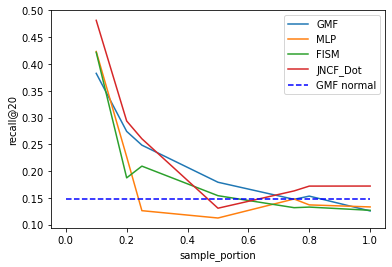

In [98]:
# GMF, MLP, 使用最大的u-i矩阵进行downsample
# 分割为train, valid, test
import numpy as np
import matplotlib.pyplot as plt
origin_score = 0.1488 # GMF
sample_portion = [0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 1.0]
sample_portion = np.array(sample_portion)
performance_dict = {'GMF':[0.3826,0.2742 ,0.2485, 0.1792, 0.1473, 0.1533,0.1256], 
                    'MLP': [0.4234, 0.2268 , 0.1261, 0.1124, 0.1479, 0.1369,0.1331],
                    'FISM': [0.4219,0.1874,0.2093,0.1541,0.1317,0.1328,0.1268],
                    'JNCF_Dot': [0.4816,0.2936,0.2604,0.1307,0.1630,0.1720,0.1721]} # recall20, 0.1332

plt.figure()
for k in performance_dict:
    performance_dict[k] = np.array(performance_dict[k])
    plt.plot(sample_portion, performance_dict[k], label=k)
# plt.plot(sample_portion, performance_dict['MLP'], color='chocolate', label='MLP')
plt.plot([0, 1.], [origin_score, origin_score], c='b', linestyle='--', label='GMF normal')
plt.xlabel('sample_portion')
plt.ylabel('recall@20')# AUC
plt.legend() # 添加图例
# Graph vs subgraphs
# srcc vs. sample portion (different sample methods, )

# add gcn + sample framework

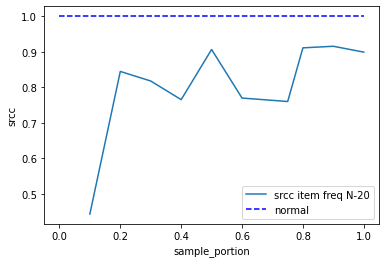

In [99]:
# srcc, anchor num = 20
import matplotlib.pyplot as plt
origin_score = 0.1488 # GMF
sample_portion = [0.1, 0.2,0.3,0.4, 0.5, 0.6,0.75, 0.8, 0.9, 1.0]
            # 0.5316271089184414, #0.25
srcc_list = [0.4434389140271493,0.8448804762131605, 
            0.8179209853255203,
             0.7654135338345864,0.9066967644845748,
             0.7699248120300751,0.7601809954751131,
             0.9112781954887217, 0.9157261098570354, 0.8992481203007519]

plt.plot(sample_portion, srcc_list, label='srcc item freq N-20')
plt.plot([0, 1.], [1., 1.], c='b', linestyle='--', label='normal')
plt.xlabel('sample_portion')
plt.ylabel('srcc') # AUC
plt.legend() 

Text(0, 0.5, 'srcc')

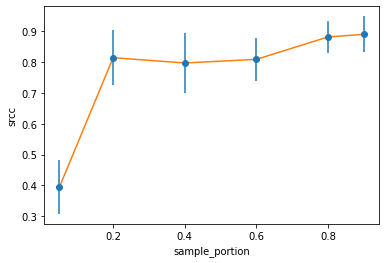

In [100]:
from sklearn.utils import shuffle
import numpy as np
a = list(range(1,10,1))
b = list(range(101,110,1))
shuffle(a,b)
srcclist_dict = {'0.05': [0.2840624656086199, 0.32075985557462455,
                        0.3291081884072281,0.49620912559521674,
                        0.4344479062386131,0.5035650084624292], # sp=0.05, config num=40
                '0.2': [0.8958528962384132, 0.8665290184594854,
                        0.8326999091548971, 0.5934421615536167,
                        0.7847352921062751, 0.8562178324241179,
                        0.8562168073622537, 0.8305683477480386], # sp=0.2, config num=40
                '0.4': [0.894507248040673,0.8740254604352637,
                        0.8521037581492852, 0.6189939939939939,
                        0.7171999588415492,0.8277172494659222 ], # sp=0.4, config num=40
                '0.6': [0.9525752884886011, 0.7670937846892223,
                        0.7757294305281922, 0.831332082551595,
                        0.7839106665856177, 0.7447337760611202 ],
                '0.8':[0.7698803871212666, 0.8918196379342448,
                        0.9072996969653808, 0.9407018156744857,
                        0.8912268933745117, 0.8904135338345863],
                '0.9': [0.9487804878048782, 0.8319490159654064]
                }
aaa09 = [0.9111618743289386]# anchor_num=80
srcc_avg = dict()
srcc_std = dict()
sample_portion = []
srcc_list = []
for sp in srcclist_dict:
    sample_portion.append(float(sp))
    srcc_avg[sp] = np.mean(srcclist_dict[sp])
    srcc_std[sp] = np.std(srcclist_dict[sp])
    srcc_list.append(srcc_avg[sp])

plt.errorbar(sample_portion, srcc_list, yerr=[srcc_std[k] for k in srcc_std], fmt="o")

plt.plot(sample_portion, srcc_list, label='srcc item freq N-20')
# plt.plot([0, 1.], [1., 1.], c='b', linestyle='--', label='normal')
plt.xlabel('sample_portion')
plt.ylabel('srcc') # AUC
# plt.legend() 

In [ ]:
device = 'cuda:0'
# scores = torch.randn(5,4)
# print(scores)
topk = 2
scores = torch.tensor([[-0.9695,  0.1512,  0.2890, -0.9094],
        [-1.4438, -0.2336,  1.4906, -0.6801],
        [ 0.6354, -0.1913, -1.6836,  0.5903],
        [ 1.0403,  0.0475,  1.6605,  2.3692],
        [ 0.3569,  1.3807,  0.5871, -0.2092]])
ground_truth = torch.FloatTensor([[2, 1, 4, 4],
                [1, 4, 1, 2],
                [4, 4, 2, 1],
                [4, 4, 4, 3],
                [3, 3, 2, 4]]).to(device)
# ground_truth = torch.FloatTensor(ground_truth)
print(ground_truth)
scores = scores.to(device)
print(scores)
values, col_indice = torch.topk(scores, k=topk)
print(values,'\n', col_indice)
row_indice = torch.zeros_like(col_indice) \
                    + torch.arange(scores.shape[0], device=device, dtype=torch.long).view(-1, 1)
print(row_indice)

print(row_indice.view(-1), col_indice.view(-1))
is_hit = ground_truth[row_indice.view(-1), col_indice.view(-1)].view(-1, topk)
print(is_hit)
is_hit = is_hit.sum(dim=1)
print(is_hit)
num_pos = ground_truth.sum(dim=1)  #positive
print(num_pos)
_cnt = scores.shape[0] - (num_pos == 0).sum().item()
_sum = (is_hit/(num_pos+1e-8)).sum().item()
print(_sum, _cnt , _sum/_cnt)

labels = torch.ones(scores.size()[0], device=scores.device)
labels = torch.reshape(labels, [-1, 1])
print(labels)

import numpy as np

def ndcg(golden, current, n = -1):
    log2_table = np.log2(np.arange(2, 102))

    def dcg_at_n(rel, n):
        rel = np.asfarray(rel)[:n]
        dcg = np.sum(np.divide(np.power(2, rel) - 1, log2_table[:rel.shape[0]]))
        return dcg

    ndcgs = []
    for i in range(len(current)):
        k = len(current[i]) if n == -1 else n
        idcg = dcg_at_n(sorted(golden[i], reverse=True), n=k)
        dcg = dcg_at_n(current[i], n=k)
        tmp_ndcg = 0 if idcg == 0 else dcg / idcg
        ndcgs.append(tmp_ndcg)
    return 0. if len(ndcgs) == 0 else sum(ndcgs) / (len(ndcgs))
a = torch.tensor([[1,2,3],[4,5,6]])
# a, a.t()